In [115]:
#Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN,Dense,Dropout
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

In [117]:
#Loading the dataset
df = pd.read_csv('AAPL.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-12,0.513393,0.515625,0.513393,0.513393,0.407747,117258400.0
1,1980-12-15,0.488839,0.488839,0.486607,0.486607,0.386473,43971200.0
2,1980-12-16,0.453125,0.453125,0.450893,0.450893,0.358108,26432000.0
3,1980-12-17,0.462054,0.464286,0.462054,0.462054,0.366972,21610400.0
4,1980-12-18,0.475446,0.477679,0.475446,0.475446,0.377609,18362400.0


In [119]:
#Getting the shape of the dataframe
df.shape

(9823, 7)

In [121]:
#Date Pre-processing
#Getting basic info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9823 entries, 0 to 9822
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       9823 non-null   object 
 1   Open       9822 non-null   float64
 2   High       9822 non-null   float64
 3   Low        9822 non-null   float64
 4   Close      9822 non-null   float64
 5   Adj Close  9822 non-null   float64
 6   Volume     9822 non-null   float64
dtypes: float64(6), object(1)
memory usage: 537.3+ KB


In [123]:
#Date column is in object data type so converting it into datatime data type
df['Date'] = pd.to_datetime(df['Date'])

In [125]:
#Checking info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9823 entries, 0 to 9822
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       9823 non-null   datetime64[ns]
 1   Open       9822 non-null   float64       
 2   High       9822 non-null   float64       
 3   Low        9822 non-null   float64       
 4   Close      9822 non-null   float64       
 5   Adj Close  9822 non-null   float64       
 6   Volume     9822 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 537.3 KB


In [127]:
#Setting Date column as index
df.set_index('Date',inplace=True)

In [129]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1980-12-12,0.513393,0.515625,0.513393,0.513393,0.407747,117258400.0
1980-12-15,0.488839,0.488839,0.486607,0.486607,0.386473,43971200.0
1980-12-16,0.453125,0.453125,0.450893,0.450893,0.358108,26432000.0
1980-12-17,0.462054,0.464286,0.462054,0.462054,0.366972,21610400.0
1980-12-18,0.475446,0.477679,0.475446,0.475446,0.377609,18362400.0


In [131]:
#Checking null values
df.isnull().sum()

Open         1
High         1
Low          1
Close        1
Adj Close    1
Volume       1
dtype: int64

In [133]:
#There is one missing value - Since Stock prices are sequential, dropping values is not the best approach
#Using Forward Fill(Where it fills with the previous days values)

df.fillna(method='ffill',inplace=True)

In [135]:
#Checking for null values
df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [137]:
# Checking for any duplicate rows
df.duplicated().sum()

1

In [139]:
# Displaying the duplicate rows
duplicates = df[df.duplicated(keep=False)]
print(duplicates)

                Open      High       Low     Close  Adj Close     Volume
Date                                                                    
1981-08-07  0.450893  0.453125  0.450893  0.450893   0.358108  2301600.0
1981-08-10  0.450893  0.453125  0.450893  0.450893   0.358108  2301600.0


In [ ]:
#Since the above duplicates is due to forward fill there is no need for removal

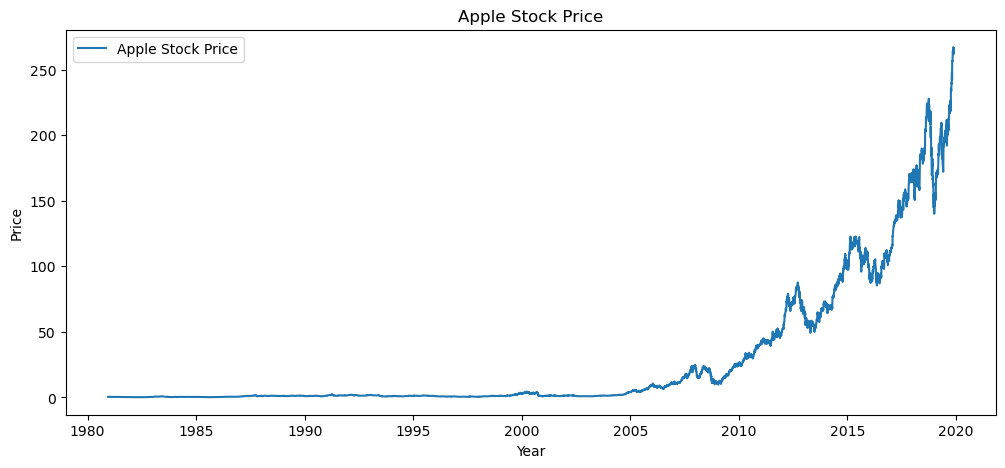

In [141]:
#Visulaization
#Selecting the adjusted Close column
df = df[['Adj Close']]

#Plotting
plt.figure(figsize=(12,5))
plt.plot(df,label='Apple Stock Price')
plt.title('Apple Stock Price')
plt.xlabel('Year')
plt.ylabel('Price')
plt.legend()
plt.show()

In [143]:
#Data Preparation for modelling
#Using Min-Max scaler as neural networks works best when features are scaled

#Initializing the scaler
scaler = MinMaxScaler(feature_range=(0,1))

#Fitting and transforming the data
df_scaled = scaler.fit_transform(df)

#Converting back to the dataframe
df_scaled = pd.DataFrame(df_scaled,index=df.index,columns=['Adj Close'])

#Checking the new dataframe
df_scaled.head()

,Adj Close
Date,
1980-12-12,0.000943
1980-12-15,0.000863
1980-12-16,0.000757
1980-12-17,0.000790
1980-12-18,0.000830


In [145]:
# Definining function to create sequences for RNN
def create_sequences(data, time_steps):
    data = np.array(data)
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])  # Past 'time_steps' days
        y.append(data[i + time_steps, 0])  # Next day's price value[1D array]
    return np.array(X), np.array(y)

In [181]:
#Applying the function
stock_prices = df_scaled.to_numpy() #Selecting Adj Clos Column

#Defining time_step(lookback period)
time_steps = 60

#Creating Sequences 
X,y = create_sequences(df_scaled,time_steps)

print(f"X Shape: {X.shape}, y Shape: {y.shape}")

X Shape: (9763, 60, 1), y Shape: (9763,)


In [183]:
# Reshape X for SimpleRNN (samples, time_steps, features)
X = X.reshape((X.shape[0], X.shape[1], 1))

In [185]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print(f"Train Shape: {X_train.shape}, Test Shape: {X_test.shape}")

Train Shape: (7810, 60, 1), Test Shape: (1953, 60, 1)


In [187]:
#Defining simple RNN
model = Sequential([
    SimpleRNN(units=20, activation='relu', return_sequences=False, input_shape=(X_train.shape[1], 1)),
    Dropout(0.4),
    Dense(units=1)   
])

In [189]:
#Compiling the model
optimizer = Adam(learning_rate = 0.0005)
model.compile(optimizer=optimizer,loss='mean_squared_error')

In [191]:
#Model Summary
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_3 (SimpleRNN)             │ (None, 20)                  │             440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 461 (1.80 KB)

 Trainable params: 461 (1.80 KB)

 Non-trainable params: 0 (0.00 B)

In [213]:
#Training the model using EarlyStopping and Modelcheckpoint

#Defining Callbacks
early_stopping = EarlyStopping(monitor='val_loss',patience=7,restore_best_weights=True)
model_checkpoint = ModelCheckpoint("AAPL_SimpleRNN.h5",monitor='val_loss',save_best_only=True)

#Training the model
history = model.fit(
    X_train,y_train,
    epochs = 50,
    batch_size = 32,
    validation_data = (X_test,y_test),
    callbacks = [early_stopping,model_checkpoint],
    verbose = 1
)

Epoch 1/50
241/245 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.4109e-04

245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.4080e-04 - val_loss: 0.0158
Epoch 2/50
231/245 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.0659e-04

245/245 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 2.0634e-04 - val_loss: 0.0154
Epoch 3/50
241/245 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.4055e-04

245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.4067e-04 - val_loss: 0.0127
Epoch 4/50
239/245 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.5211e-04

245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.5176e-04 - val_loss: 0.0119
Epoch 5/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.3781e-04 - val_loss: 0.0144
Epoch 6/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.1432e-04 - val_loss: 0.0161
Epoch 7/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.5948e-04 - val_loss: 0.0136
Epoch 8/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.1732e-04 - val_loss: 0.0131
Epoch 9/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 2.1106e-04 - val_loss: 0.0136
Epoch 10/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 2.1346e-04 - val_loss: 0.0127
Epoch 11/50
243/245 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.2450e-04

245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.2454e-04 - val_loss: 0.0118
Epoch 12/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.4784e-04 - val_loss: 0.0131
Epoch 13/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 2.2965e-04 - val_loss: 0.0127
Epoch 14/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 2.5500e-04 - val_loss: 0.0120
Epoch 15/50
237/245 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.3944e-04

245/245 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 2.3948e-04 - val_loss: 0.0108
Epoch 16/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 2.2765e-04 - val_loss: 0.0135
Epoch 17/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 2.1762e-04 - val_loss: 0.0127
Epoch 18/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 2.2738e-04 - val_loss: 0.0110
Epoch 19/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.2526e-04 - val_loss: 0.0110
Epoch 20/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.2064e-04 - val_loss: 0.0127
Epoch 21/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.1925e-04 - val_loss: 0.0111
Epoch 22/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 2.3534e-04 - val_loss: 0.0135


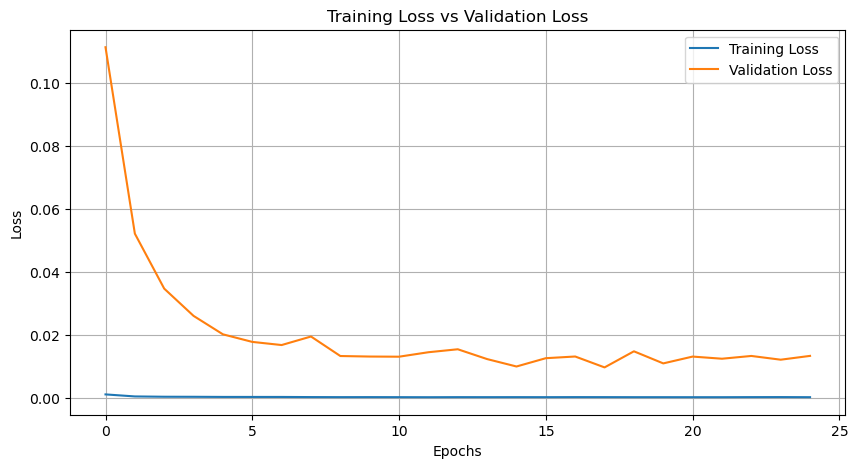

In [195]:
#Plotting Training and validation loss
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'],label='Training Loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss vs Validation Loss')
plt.legend()
plt.grid()
plt.show()

In [223]:
#Predicting the stock prices for the test data
pred_stock_prices = model.predict(X_test)

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [225]:
#Converting predictions back to actual prices
pred_stock_prices = scaler.inverse_transform(pred_stock_prices)
actual_stock_prices = scaler.inverse_transform(y_test.reshape(-1,1))

In [227]:
#Calculating MSE 
mse = mean_squared_error(actual_stock_prices,pred_stock_prices)
print(f"Mean Squared Error(MSE) : {mse}")

Mean Squared Error(MSE) : 769.4176158436211


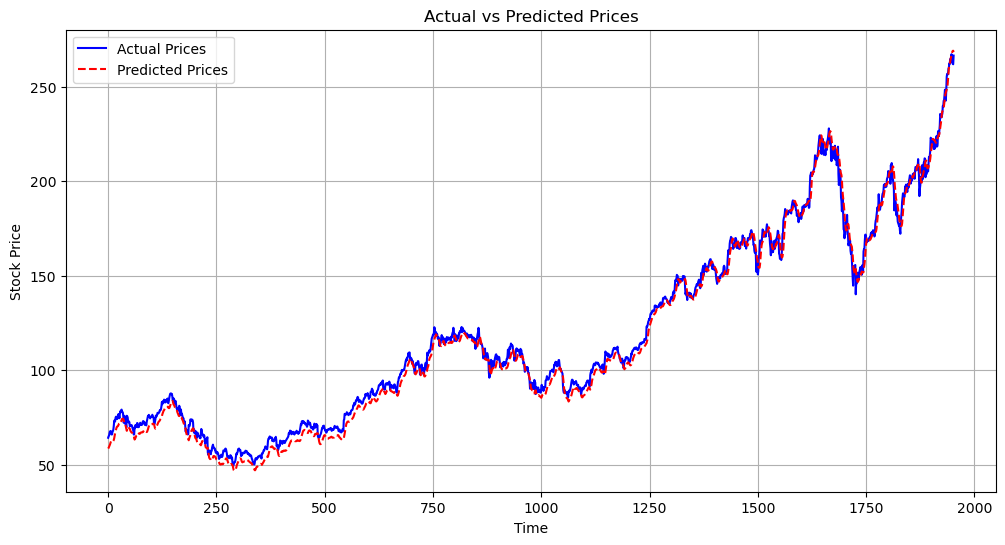

In [115]:
#Visualizing the actual and predicted stock prices
plt.figure(figsize=(12,6))
plt.plot(actual_stock_prices,label = 'Actual Prices',color = 'blue')
plt.plot(pred_stock_prices,label = 'Predicted Prices', color='red',linestyle = 'dashed')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title("Actual vs Predicted Prices")
plt.legend()
plt.grid()
plt.show()

In [131]:
def predict_next_day(model, last_sequence, scaler):

    # Reshaping last sequence to match model input shape (1, 60, 1)
    last_sequence = last_sequence.reshape(1, last_sequence.shape[0], 1)

    # Predicting next day's price 
    predicted_scaled = model.predict(last_sequence)

    # Using Inverse transform to get actual price
    next_day_price = scaler.inverse_transform(predicted_scaled.reshape(-1, 1))[0, 0]

    return next_day_price


# Extracting the last sequence from X_test
last_sequence = X_test[-1]  # This takes the last available sequence
print(f"Last sequence shape: {last_sequence.shape}")

# Predict the next day's price
next_day_price = predict_next_day(model, last_sequence, scaler)
print(f"Predicted stock price for the next day: ${next_day_price:.5f}")


Last sequence shape: (60, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Predicted stock price for the next day: $268.23807


In [127]:
def predict_next_5_days(model, last_sequence, scaler):

    predictions = []
    current_sequence = last_sequence.copy()  # Copying to avoid modifying original

    for _ in range(5):
        # Reshape for prediction
        current_sequence_reshaped = current_sequence.reshape(1, current_sequence.shape[0], 1)

        # Predict next day's price
        predicted_scaled = model.predict(current_sequence_reshaped)
        predicted_price = scaler.inverse_transform(predicted_scaled.reshape(-1, 1))[0, 0]

        # Storing the prediction
        predictions.append(predicted_price)

        # Update sequence: remove first value, append predicted value
        current_sequence = np.roll(current_sequence, -1)
        current_sequence[-1] = predicted_scaled  # Append new prediction

    return predictions

# Predicting stock prices for the next 5 days
next_5_days_prices = predict_next_5_days(model, last_sequence, scaler)
print(f"Predicted stock prices for the next 5 days: ${next_5_days_prices}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Predicted stock prices for the next 5 days: $[268.23807, 268.00827, 267.84427, 268.79752, 270.62558]


In [139]:
def predict_next_10_days(model,last_sequence,scaler):
    predictions = []
    current_sequence = last_sequence.copy()

    for _ in range(10):
        current_sequence_reshaped = current_sequence.reshape(1,current_sequence.shape[0],1)

        #Predicting next day's prices
        predicted_scaled = model.predict(current_sequence_reshaped)
        predicted_price = scaler.inverse_transform(predicted_scaled.reshape(-1,1))[0,0]

        #Storing the predictions
        predictions.append(predicted_price)

        # Updating sequence: remove first value, append predicted value
        current_sequence = np.roll(current_sequence,-1)
        current_sequence[-1] = predicted_scaled    #appending new prediction

    return predictions

next_10_days_prices = predict_next_10_days(model,last_sequence,scaler)
print(f"Predicted Stock prices fot the next 10 days: {next_10_days_prices}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Predicted Stock prices fot the next 10 days: [268.23807, 268.00827, 267.84427, 268.79752, 270.62558, 272.1009, 273.0738, 274.06784, 275.29303, 276.6051]


In [141]:
#Saving the model
model.save("Final_AAPL_SimpleRNN.h5")